In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.feature_selection import SelectKBest, chi2
from tqdm.notebook import tqdm
from sklearn import metrics
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('parkinson_disease.csv')
pd.set_option('display.max_columns', 10)
df.sample(5)

,id,gender,PPE,DFA,RPDE,...,tqwt_kurtosisValue_dec_33,tqwt_kurtosisValue_dec_34,tqwt_kurtosisValue_dec_35,tqwt_kurtosisValue_dec_36,class
478,159,0,0.73974,0.77915,0.59230,...,3.1998,3.1785,4.0573,4.0402,1
269,89,0,0.83040,0.59032,0.25695,...,3.8156,10.0111,8.2614,7.2913,0
593,197,0,0.83045,0.71832,0.26936,...,3.1681,3.9787,4.8948,3.5699,1
585,195,1,0.83915,0.65746,0.32060,...,3.1761,2.4711,2.3540,4.4296,0
633,211,0,0.84386,0.75649,0.43172,...,3.1839,4.1253,4.5805,3.7793,1


In [3]:
 """
Displays the total number of rows and columns, the data types of each column and the count of non-null values.
 This helps identify missing data and column types.
 """
 print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 756 entries, 0 to 755
Columns: 755 entries, id to class
dtypes: float64(749), int64(6)
memory usage: 4.4 MB
None


In [4]:
"""
Provides a transposed statistical summary of numerical columns, 
including the mean, standard deviation, minimum and maximum values as well as quartiles.
 This helps us understand the distribution of the data.
"""
df.describe().T

,count,mean,std,min,25%,50%,75%,max
id,756.0,125.500000,72.793721,0.000000,62.750000,125.500000,188.250000,251.00000
gender,756.0,0.515873,0.500079,0.000000,0.000000,1.000000,1.000000,1.00000
PPE,756.0,0.746284,0.169294,0.041551,0.762833,0.809655,0.834315,0.90766
DFA,756.0,0.700414,0.069718,0.543500,0.647053,0.700525,0.754985,0.85264
RPDE,756.0,0.489058,0.137442,0.154300,0.386537,0.484355,0.586515,0.87123
...,...,...,...,...,...,...,...,...
tqwt_kurtosisValue_dec_33,756.0,12.375335,16.341665,1.628700,3.114375,4.741450,12.201325,73.53220
tqwt_kurtosisValue_dec_34,756.0,14.799230,15.722502,1.861700,3.665925,6.725700,21.922050,62.00730
tqwt_kurtosisValue_dec_35,756.0,14.751559,14.432979,1.955900,3.741275,7.334250,22.495175,57.54430
tqwt_kurtosisValue_dec_36,756.0,31.481110,34.230991,2.364000,3.948750,10.637250,61.125325,156.42370


In [5]:
df.isnull().sum().sum()

0

## Data Wrangling

Data wrangling involves restructuring and transforming the dataset to make it suitable for analysis. Since our dataset contains three observations for each patient we need to aggregate them to create a single representative record per patient
-> df.groupby('id').mean().reset_index(): Groups the dataset by the "id" column and calculates the mean of numerical features. This helps in aggregating multiple records of the same id (patient id).
-> df.drop('id', axis=1, inplace=True): Removes the "id" column as it is no longer needed after aggregation.

In [6]:
df = df.groupby('id').mean().reset_index()
df.drop('id', axis=1, inplace=True)

## Multicollinearity 

Multicollinearity can negatively impact machine learning models by making them unstable and less interpretable. To handle this we identify and remove highly correlated features from our dataset. In this code:

df[col].corr(df[col1]): Computes the Pearson correlation coefficient between two numerical features.
If correlation > 0.7: The feature is considered highly correlated and is removed from the dataset to reduce redundancy.
The class column is excluded: Since it represents the target variable, we do not check its correlation with other features.

In [7]:
columns = list(df.columns)
for col in columns:
    if col == 'class':
        continue

    filtered_columns = [col]
    for col1 in df.columns:
        if((col == col1) | (col == 'class')):
            continue

        val = df[col].corr(df[col1])
        if val > 0.7:
            # If the correlation between the two features is more than 0.7, remove it
            columns.remove(col1)
            continue
        else:
            filtered_columns.append(col1)
            
    df = df[filtered_columns]
df.shape

(252, 287)

 ## Feature Selection
To improve model performance and reduce computational complexity we apply feature selection using the chi-square test to retain only the most relevant features. This helps eliminate redundant or less significant variables making the dataset more efficient for machine learning. Here:

X = df.drop('class', axis=1): Extracts the feature set by removing the target variable (class).
MinMaxScaler().fit_transform(X): Normalizes the feature values to a range of [0,1] using Min-Max Scaling. This ensures that all features contribute equally to the model.
SelectKBest(chi2, k=30): Applies the Chi-Square test to select the 30 most important features based on their relationship with the target variable (class).
selector.fit(X_norm, df['class']): Fits the feature selection model on the normalized data.
filtered_columns = selector.get_support(): Identifies the selected features.
filtered_data = X.loc[:, filtered_columns]: Extracts only the top 30 selected features.
filtered_data['class'] = df['class']: Reattaches the target variable (class) to the reduced dataset.

In [8]:
X = df.drop('class', axis=1)
X_norm = MinMaxScaler().fit_transform(X)
selector = SelectKBest(chi2, k=30)
selector.fit(X_norm, df['class'])
filtered_columns = selector.get_support()
filtered_data = X.loc[:, filtered_columns]
filtered_data['class'] = df['class']
df = filtered_data
df.shape

(252, 31)

## Handling Class Imbalance and Splitting Data
To understand the distribution of target classes in our dataset, we use a pie chart. This helps us check for class imbalances, which can impact model performance.

df['class'].value_counts(): Counts the occurrences of each class in the dataset.
plt.pie(x.values, labels=x.index, autopct='%1.1f%%'): Creates a pie chart
x.values: Represents the frequency of each class.
labels=x.index: Assigns class labels to each slice.
autopct='%1.1f%%': Displays percentages with one decimal place.
This visualization helps us assess whether the dataset is balanced or imbalanced which is crucial when selecting appropriate evaluation metrics and model strategies

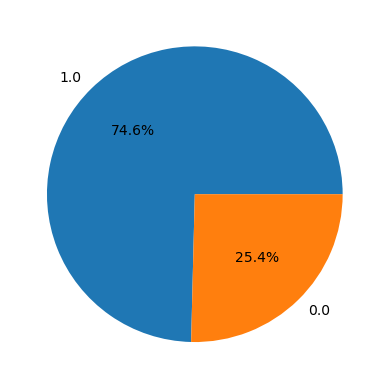

In [9]:
x = df['class'].value_counts()
plt.pie(x.values,
        labels = x.index,
        autopct='%1.1f%%')
plt.show()

## Train the model
To build a robust machine learning model we need to address this class imbalance and properly split the dataset into training and validation sets. If the dataset is imbalanced the model may become biased toward the majority class making it difficult to correctly predict the minority class. Here: :

features = df.drop('class', axis=1): Extracts and stores independent variables.
target = df['class']: Stores the dependent variable.:
train_test_split(features, target, test_size=0.2, random_state=10): Allocates 80% of data for training and 20% for validation
random_state=10 ensures reproducibility.
ros = RandomOverSampler(sampling_strategy='minority', random_state=0): Oversamples the minority class ensuring both classes have equal representation.
ros.fit_resample(X_train, Y_train): Applies oversampling to the training dataset.

In [13]:
features = df.drop('class', axis=1)
target = df['class']

X_train, X_val,Y_train, Y_val = train_test_split(features, target,
                                      test_size=0.2,
                                      random_state=10)

ros = RandomOverSampler(sampling_strategy=1.0,
                        random_state=0)
X, Y = ros.fit_resample(X_train, Y_train)
X.shape, Y.value_counts()




((302, 30),
 class
 1.0    151
 0.0    151
 Name: count, dtype: int64)

## Model Training and Evaluation
After preparing the dataset, we train multiple machine learning models and evaluate their performance using the ROC AUC Score. This helps us compare different models and choose the best-performing one for our classification task. Here we are using three different classifiers : Logistic Regression, XGBoost Classifier and Support Vector Classifier.

model.fit(X_resampled, y_resampled: Trains each model in the "models" list .
model.predict(X_resampled): Predicts outcomes on the training data.
ras(y_resampled, train_preds): Computes the ROC AUC score for training accuracy.
model.predict(X_val): Predicts outcomes on the validation dataset.
ras(y_val, val_preds): Computes the ROC AUC score for validation accuracy.

In [14]:
from sklearn.metrics import roc_auc_score as ras

models = [LogisticRegression(class_weight='balanced'), XGBClassifier(), SVC(kernel='rbf', probability=True)] 
for model in models:
    model.fit(X_train, Y_train)
    print(f'{model} : ')

    train_preds = model.predict(X_train)
    print('Training Accuracy : ', ras(Y_train, train_preds))

    val_preds = model.predict(X_val)
    print('Validation Accuracy : ', ras(Y_val, val_preds))
    print()

LogisticRegression(class_weight='balanced') : 
Training Accuracy :  0.7872185430463576
Validation Accuracy :  0.803088803088803

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...) : 
Training Accuracy :  1.0
Validation Accuracy :  0.722972972972973

SVC(probability=True) : 
Training Accura

 ## Analyzing Model Performance
We will now plot confusion matrix on validation data for the Logistic Regression model to further evaluate the model's predictive capability.

ConfusionMatrixDisplay.from_estimator(models[0], X_val, y_val): Uses the first model in the list (which is Logistic Regression) to make predictions on the validation set (X_val).
It then compares these predictions to the actual labels y_val to generate a confusion matrix.

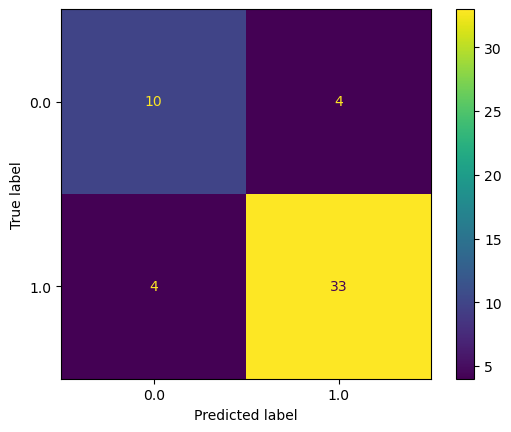

In [15]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_estimator(models[0], X_val, Y_val)
plt.show()

In [16]:
from sklearn.metrics import classification_report
print(classification_report(Y_val, models[0].predict(X_val)))

              precision    recall  f1-score   support

         0.0       0.71      0.71      0.71        14
         1.0       0.89      0.89      0.89        37

    accuracy                           0.84        51
   macro avg       0.80      0.80      0.80        51
weighted avg       0.84      0.84      0.84        51

